## Covid-19 forecasting using Facebook Prophet and ARIMA model

 **Importing all the python libraries we would be needing for this project.**

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins
from sklearn.metrics import r2_score
import itertools
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 10,12

**The next step is collecting data. Collecting is the process of gathering new data from internet,using API, databases and other sources.
Once you have the data you need, you can read the datasets and store them into a Pandas DataFrame.**

In [2]:
df = pd.read_csv('../../DataScraper/macedonia-data.csv')
df_italy = pd.read_csv('../../DataScraper/italy.csv')
df_spain = pd.read_csv('../../DataScraper/spain.csv')

In [3]:
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26
...,...,...,...,...,...,...,...
258,"Macedonia, Republic of",MK,19096,768,15645,2683,2020-10-06
259,"Macedonia, Republic of",MK,19413,772,15749,2892,2020-10-07
260,"Macedonia, Republic of",MK,19777,775,15855,3147,2020-10-08
261,"Macedonia, Republic of",MK,20163,781,16009,3373,2020-10-09


**The *info()* function is used to print a concise summary of a DataFrame. This method prints information about a DataFrame including the index dtype and column dtypes, total entries, non-null values and memory usage.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   COUNTRY       263 non-null    object
 1   COUNTRY_CODE  263 non-null    object
 2   CONFIRMED     263 non-null    int64 
 3   DEATHS        263 non-null    int64 
 4   RECOVERED     263 non-null    int64 
 5   ACTIVE        263 non-null    int64 
 6   DATE          263 non-null    object
dtypes: int64(4), object(3)
memory usage: 14.5+ KB


**The next step is *Feature Engineering*. Feature Engineering being the process of using domain knowledge to extract features from raw data via data mining techniques. For the context of this publication, a new features like DAILY NEW CASES, DAILY NEW DEATHS, DAILY CURERED are created.**

In [5]:
df['DAILY NEW CASES'] = df['CONFIRMED'] - df['CONFIRMED'].shift(1)
df['DAILY NEW DEATHS'] = df['DEATHS'] - df['DEATHS'].shift(1)
df['DAILY CURED'] = df['RECOVERED'] - df['RECOVERED'].shift(1)

In [6]:
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22,NaN,NaN,NaN
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
258,"Macedonia, Republic of",MK,19096,768,15645,2683,2020-10-06,223.0,8.0,158.0
259,"Macedonia, Republic of",MK,19413,772,15749,2892,2020-10-07,317.0,4.0,104.0
260,"Macedonia, Republic of",MK,19777,775,15855,3147,2020-10-08,364.0,3.0,106.0
261,"Macedonia, Republic of",MK,20163,781,16009,3373,2020-10-09,386.0,6.0,154.0


**Fill *NaN* values with zero.**

In [7]:
df['DAILY NEW CASES'] = df['DAILY NEW CASES'].fillna(0)
df['DAILY NEW DEATHS'] = df['DAILY NEW DEATHS'].fillna(0)
df['DAILY CURED'] = df['DAILY CURED'].fillna(0)
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22,0.0,0.0,0.0
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
258,"Macedonia, Republic of",MK,19096,768,15645,2683,2020-10-06,223.0,8.0,158.0
259,"Macedonia, Republic of",MK,19413,772,15749,2892,2020-10-07,317.0,4.0,104.0
260,"Macedonia, Republic of",MK,19777,775,15855,3147,2020-10-08,364.0,3.0,106.0
261,"Macedonia, Republic of",MK,20163,781,16009,3373,2020-10-09,386.0,6.0,154.0


**By default, the data type for the *‘Date’* feature is a string str , for proper time series analysis, we have to convert that feature to a datetime datatype using the Pandas *to_datetime* method.**

In [8]:
df['DATE'] = pd.to_datetime(df['DATE'])

**Data Aggregation. In order to show daily new cases by month, this is a step that can't be missed.**

In [10]:
total_per_month_df = df.groupby(df['DATE'].dt.strftime('%B'))['DAILY NEW CASES'].sum().sort_values(ascending=False).to_frame()
total_per_month_df.style.background_gradient(cmap='Reds')

,DAILY NEW CASES
DATE,
July,4420.000000
June,4108.000000
September,3636.000000
August,3587.000000
October,2578.000000
April,1136.000000
May,761.000000
March,328.000000
February,1.000000


**In the next cell, the goal is to create a dataframe with three columns *(Total Cases, Total Deaths and Total Cured patients)* by month.**

In [11]:
total_per_month_df = df.groupby(df['DATE'].rename("MONTH").dt.strftime('%B')).agg(
TOTAL_CASES = pd.NamedAgg(column='DAILY NEW CASES', aggfunc=sum),
TOTAL_DEATHS = pd.NamedAgg(column='DAILY NEW DEATHS', aggfunc=sum),
TOTAL_CURED = pd.NamedAgg(column='DAILY CURED', aggfunc=sum),
)

In [12]:
total_per_month_df

,TOTAL_CASES,TOTAL_DEATHS,TOTAL_CURED
MONTH,,,
April,1136.0,68.0,726.0
August,3587.0,117.0,4603.0
February,1.0,0.0,0.0
January,0.0,0.0,0.0
July,4420.0,184.0,4079.0
June,4108.0,169.0,923.0
March,328.0,9.0,12.0
May,761.0,56.0,814.0
October,2578.0,46.0,1140.0


**Data Visualization 
<br>
To help understanding of the aggregated data, a graphical representation via plotting the data is crucial.**

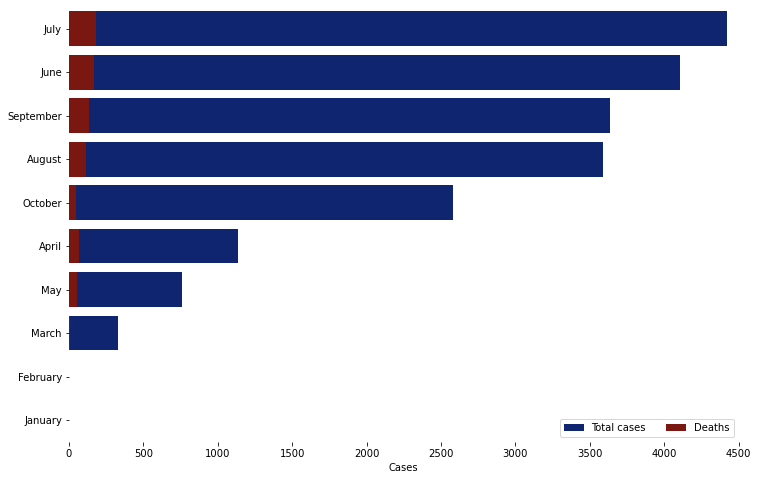

In [13]:
f, ax = plt.subplots(figsize = (12,8))
data = total_per_month_df.copy()
data['MONTH'] = data.index
data.sort_values('TOTAL_CASES', ascending =  False, inplace = True)
sns.set_color_codes("dark")
sns.barplot(x = "TOTAL_CASES", y = "MONTH", data = data, label = "Total cases", color = "b")
sns.set_color_codes("dark")
sns.barplot(x = "TOTAL_DEATHS", y = "MONTH", data = data, label = "Deaths", color = "r")

ax.legend(ncol = 2, loc = "lower right", frameon = True)
ax.set(xlim = (0, 4500), ylabel = "", xlabel="Cases")
sns.despine(left = True, bottom = True)


In [14]:
import plotly
plotly.io.renderers.default = 'browser'

**By running the next two cells, there is a graphical representation of our previous dataframe, where x axis is the date and y axis is the number of daily new cases with Covid-19. Also, there are a hover actions to this visualization, which means if you hover on point(which represents a date between January and August), you're gonna notice a pop up window with number of Covid-19 cases for that day.**

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['DATE'], y=df['DAILY NEW CASES'], mode='lines+markers', name='Total Cases'))
fig.update_layout(title_text='Coronavirus cases in North Macedonia', plot_bgcolor='rgb(230,230,230)')
fig.show()

In [16]:
import plotly.express as px
fig = px.bar(df, x="DATE", y= "DAILY NEW CASES", barmode='group', height = 400)
fig.update_layout(title_text='Coronavirus cases in North Macedonia', plot_bgcolor='rgb(230,230,230)')
fig.show()

**As I mentioned before, the data type for the *‘Date’* feature is a string and we have to convert that feature to a datetime datatype using the Pandas *to_datetime* method.** 

In [17]:
df_italy['DATE'] = pd.to_datetime(df_italy['DATE'])
df_spain['DATE'] = pd.to_datetime(df_spain['DATE'])

**Create new features from the existing ones and then fill *NaN* values with zero. The identical process is for Italy and Spain.**

In [18]:
df_italy['DAILY NEW CASES'] = df_italy['CONFIRMED'] - df_italy['CONFIRMED'].shift(1)
df_italy['DAILY NEW DEATHS'] = df_italy['DEATHS'] - df_italy['DEATHS'].shift(1)
df_italy['DAILY CURED'] = df_italy['RECOVERED'] - df_italy['RECOVERED'].shift(1)

In [19]:
df_italy['DAILY NEW CASES'] = df_italy['DAILY NEW CASES'].fillna(0)
df_italy['DAILY NEW DEATHS'] = df_italy['DAILY NEW DEATHS'].fillna(0)
df_italy['DAILY CURED'] = df_italy['DAILY CURED'].fillna(0)
df_italy

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,Italy,IT,0,0,0,0,2020-01-22,0.0,0.0,0.0
1,Italy,IT,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,Italy,IT,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,Italy,IT,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,Italy,IT,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
258,Italy,IT,330263,36030,234099,60134,2020-10-06,2677.0,28.0,1418.0
259,Italy,IT,333940,36061,235303,62576,2020-10-07,3677.0,31.0,1204.0
260,Italy,IT,338398,36083,236363,65952,2020-10-08,4458.0,22.0,1060.0
261,Italy,IT,343770,36111,237549,70110,2020-10-09,5372.0,28.0,1186.0


In [20]:
df_spain['DAILY NEW CASES'] = df_spain['CONFIRMED'] - df_spain['CONFIRMED'].shift(1)
df_spain['DAILY NEW DEATHS'] = df_spain['DEATHS'] - df_spain['DEATHS'].shift(1)
df_spain['DAILY CURED'] = df_spain['RECOVERED'] - df_spain['RECOVERED'].shift(1)

In [21]:
df_spain['DAILY NEW CASES'] = df_spain['DAILY NEW CASES'].fillna(0)
df_spain['DAILY NEW DEATHS'] = df_spain['DAILY NEW DEATHS'].fillna(0)
df_spain['DAILY CURED'] = df_spain['DAILY CURED'].fillna(0)
df_spain
mean = df_spain["DAILY NEW CASES"].mean()
df_spain[df_spain['DAILY NEW CASES'] < 0] = mean
df_spain
       

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,Spain,ES,0.0,0.0,0.0,0.0,2020-01-22 00:00:00,0.0,0.0,0.0
1,Spain,ES,0.0,0.0,0.0,0.0,2020-01-23 00:00:00,0.0,0.0,0.0
2,Spain,ES,0.0,0.0,0.0,0.0,2020-01-24 00:00:00,0.0,0.0,0.0
3,Spain,ES,0.0,0.0,0.0,0.0,2020-01-25 00:00:00,0.0,0.0,0.0
4,Spain,ES,0.0,0.0,0.0,0.0,2020-01-26 00:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
258,Spain,ES,825410.0,32486.0,150376.0,642548.0,2020-10-06 00:00:00,11998.0,261.0,0.0
259,Spain,ES,835901.0,32562.0,150376.0,652963.0,2020-10-07 00:00:00,10491.0,76.0,0.0
260,Spain,ES,848324.0,32688.0,150376.0,665260.0,2020-10-08 00:00:00,12423.0,126.0,0.0
261,Spain,ES,861112.0,32929.0,150376.0,677807.0,2020-10-09 00:00:00,12788.0,241.0,0.0


**Comparing each country's growing number of coronavirus cases on the same time using Plotly - Python graphing library.**

In [22]:
from plotly.subplots import make_subplots

fig = make_subplots(
rows = 2, cols =2,
specs= [[{},{}],
        [{"colspan": 2}, None]],
subplot_titles=("North Macedonia", "Italy", "Spain"))

fig.add_trace(go.Bar(x=df['DATE'], \
                     y = df['DAILY NEW CASES'], \
                     marker = dict(color = df['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=1 , col=1)

fig.add_trace(go.Bar(x=df_italy['DATE'], \
                     y = df_italy['DAILY NEW CASES'], \
                     marker = dict(color = df_italy['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=1 , col=2)

fig.add_trace(go.Bar(x=df_spain['DATE'], \
                     y = df_spain['DAILY NEW CASES'], \
                     marker = dict(color = df_spain['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=2, col=1)

fig.update_layout(coloraxis=dict(colorscale = 'Bluered_r'), showlegend = False)

fig.update_layout(plot_bgcolor='rgb(230,230,230)')

fig.show()

**Forecast the number of Covid-19 cases using Facebook Prophet.<br>
From the official documentation: "Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well." <br>
As this project contains time series data, I decided to try how would it work.**

In [23]:
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet

In [24]:
data = pd.read_csv('./covid19-data.csv')

In [25]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
1,2020-01-23,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
2,2020-01-24,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
3,2020-01-25,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
4,2020-01-26,Afghanistan,NaN,33.93911,67.709953,0,0.0,0


In [26]:
data.corr()

,Lat,Long,Confirmed,Recovered,Deaths
Lat,1.000000,-0.119971,0.009679,-0.011689,0.041781
Long,-0.119971,1.000000,-0.071795,-0.059754,-0.113494
Confirmed,0.009679,-0.071795,1.000000,0.921559,0.910230
Recovered,-0.011689,-0.059754,0.921559,1.000000,0.776148
Deaths,0.041781,-0.113494,0.910230,0.776148,1.000000


In [27]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data['CurrentCase'] = data['Confirmed'] - data['Recovered'] - data['Deaths']

In [28]:
date_df = data.groupby('Date')[['Confirmed' ,'Recovered', 'Deaths', 'CurrentCase']].sum()

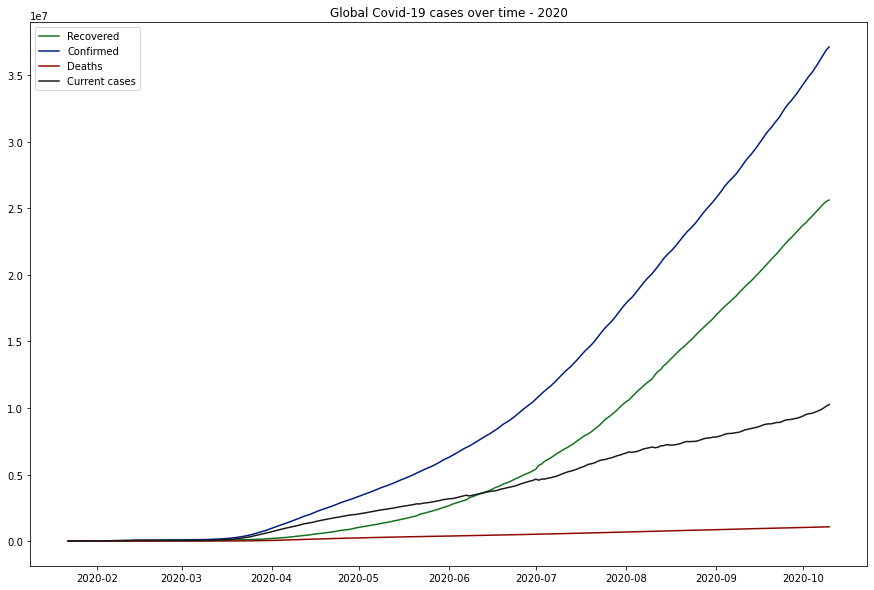

In [29]:
plt.figure(figsize=(15,10))
plt.plot(date_df["Recovered"],color='g',label='Recovered')
plt.plot(date_df["Confirmed"],color='b', label='Confirmed')
plt.plot(date_df["Deaths"],color='r',label='Deaths')
plt.plot(date_df['CurrentCase'],color='k', label='Current cases')
plt.title('Global Covid-19 cases over time - 2020')
plt.legend();

**Before I start with forecasting, I would like to say a few important things and concepts about how Prophet works: <br>
The Prophet forecasting model contains three main model components: trend, seasonality, and holidays. They are combined in the following equation:  `y(t) = g(t) + s(t) + h(t) + εt` , where<br>
`g(t)`: piecewise linear or logistic growth curve for modelling non-periodic changes in time series<br>
`s(t)`: periodic changes (e.g. weekly/yearly seasonality)<br>
`h(t)`: effects of holidays (user provided) with irregular schedules<br>
`εt`: error term accounts for any unusual changes not accommodated by the model<br>
Prophet requires the variable names in the time series to be:<br>
`y` – Target, must be numeric, and represents the measurement we wish to forecast.<br>
`ds` – Datetime**

In [30]:
model = Prophet()
model.add_seasonality(name='Monthly', period=30.42, fourier_order=5)

In [31]:
global_cases = date_df.reset_index()
confirmed_df = global_cases[['Date', 'Confirmed']]
recovered_df = global_cases[['Date', 'Recovered']]
deaths_df = global_cases[['Date', 'Deaths']]
current_df = global_cases[['Date', 'CurrentCase']]

**`rename_func` is a function that renames a dataframe columns name to `ds` and `y`, respectively.**

In [32]:
def rename_func(dataframe):
    cols = dataframe.columns
    dataframe = dataframe.rename(columns= {cols[0]: 'ds', cols[1]:'y'})
    return dataframe

In [33]:
confirmed_df = rename_func(confirmed_df)
recovered_df = rename_func(recovered_df)
deaths_df = rename_func(deaths_df)
current_df = rename_func(current_df)

**`train_test_split` function splits the dataset to training dataset and validation dataset by the *Pareto* principle(80:20)**

In [34]:
def train_test_split(dataframe, ratio):
    divisor = round((ratio/100)*dataframe.shape[0])
    train = dataframe.iloc[:divisor]
    test = dataframe.iloc[divisor:]
    return train, test, divisor

**`check_metrics` function caluclates the root squared error.<br> *R2(root sqared error)* is also called *coefficient of determination*. Coefficient of determination normally ranges from 0 to 1. That value is a statistical measure of how well the regression predictions approximate the real data points. <br>An R2 of 1 indicates that the regression predictions perfectly fit the data.**

In [35]:
def check_metrics(test, predictions):
    R2_score = r2_score(test['y'],predictions['yhat'].iloc[divisor:])
    print(f"R-square Score: {R2_score}")

**Predicting the number of confirmed cases of novel coronavirus disease - WORLD**

In [36]:
# World
data_world = rename_func(confirmed_df)
m = Prophet()
m.add_seasonality(name='Monthly', period=30.42, fourier_order=5)
daily_new_train, daily_new_test, divisor = train_test_split(data_world, 80)
daily_new_train.shape , daily_new_test.shape
m.fit(daily_new_train)
future_dates_world = m.make_future_dataframe(periods=53)
predictions_world = m.predict(future_dates_world)
predictions_world.tail()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
258,2020-10-06,3.421929e+07,3.262720e+07,3.601982e+07,3.260922e+07,3.592742e+07,71438.434424,71438.434424,71438.434424,62556.041993,62556.041993,62556.041993,-8882.392431,-8882.392431,-8882.392431,0.0,0.0,0.0,3.428184e+07
259,2020-10-07,3.446758e+07,3.283995e+07,3.627522e+07,3.277149e+07,3.622935e+07,76575.909138,76575.909138,76575.909138,68225.511394,68225.511394,68225.511394,-8350.397744,-8350.397744,-8350.397744,0.0,0.0,0.0,3.453581e+07
260,2020-10-08,3.471587e+07,3.300620e+07,3.663871e+07,3.292912e+07,3.653137e+07,75361.023001,75361.023001,75361.023001,75688.676134,75688.676134,75688.676134,327.653133,327.653133,327.653133,0.0,0.0,0.0,3.479156e+07
261,2020-10-09,3.496417e+07,3.318494e+07,3.691632e+07,3.313109e+07,3.681855e+07,68788.709725,68788.709725,68788.709725,79512.341484,79512.341484,79512.341484,10723.631758,10723.631758,10723.631758,0.0,0.0,0.0,3.504368e+07
262,2020-10-10,3.521246e+07,3.338436e+07,3.720792e+07,3.331398e+07,3.716696e+07,59233.901961,59233.901961,59233.901961,71816.102221,71816.102221,71816.102221,12582.200260,12582.200260,12582.200260,0.0,0.0,0.0,3.528428e+07


In [37]:
daily_new_train.tail()

,ds,y
205,2020-08-14,21206137
206,2020-08-15,21454001
207,2020-08-16,21666057
208,2020-08-17,21876108
209,2020-08-18,22132478


In [38]:
predictions_world.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
258,2020-10-06,3.421929e+07,3.262720e+07,3.601982e+07,3.260922e+07,3.592742e+07,71438.434424,71438.434424,71438.434424,62556.041993,62556.041993,62556.041993,-8882.392431,-8882.392431,-8882.392431,0.0,0.0,0.0,3.428184e+07
259,2020-10-07,3.446758e+07,3.283995e+07,3.627522e+07,3.277149e+07,3.622935e+07,76575.909138,76575.909138,76575.909138,68225.511394,68225.511394,68225.511394,-8350.397744,-8350.397744,-8350.397744,0.0,0.0,0.0,3.453581e+07
260,2020-10-08,3.471587e+07,3.300620e+07,3.663871e+07,3.292912e+07,3.653137e+07,75361.023001,75361.023001,75361.023001,75688.676134,75688.676134,75688.676134,327.653133,327.653133,327.653133,0.0,0.0,0.0,3.479156e+07
261,2020-10-09,3.496417e+07,3.318494e+07,3.691632e+07,3.313109e+07,3.681855e+07,68788.709725,68788.709725,68788.709725,79512.341484,79512.341484,79512.341484,10723.631758,10723.631758,10723.631758,0.0,0.0,0.0,3.504368e+07
262,2020-10-10,3.521246e+07,3.338436e+07,3.720792e+07,3.331398e+07,3.716696e+07,59233.901961,59233.901961,59233.901961,71816.102221,71816.102221,71816.102221,12582.200260,12582.200260,12582.200260,0.0,0.0,0.0,3.528428e+07


R-square Score: 0.958036398948873


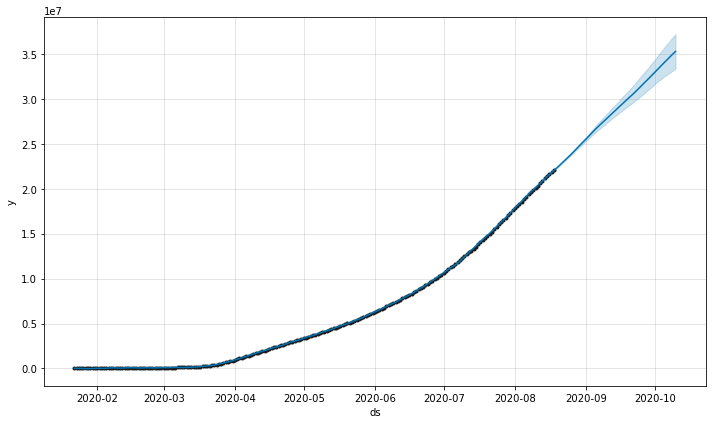

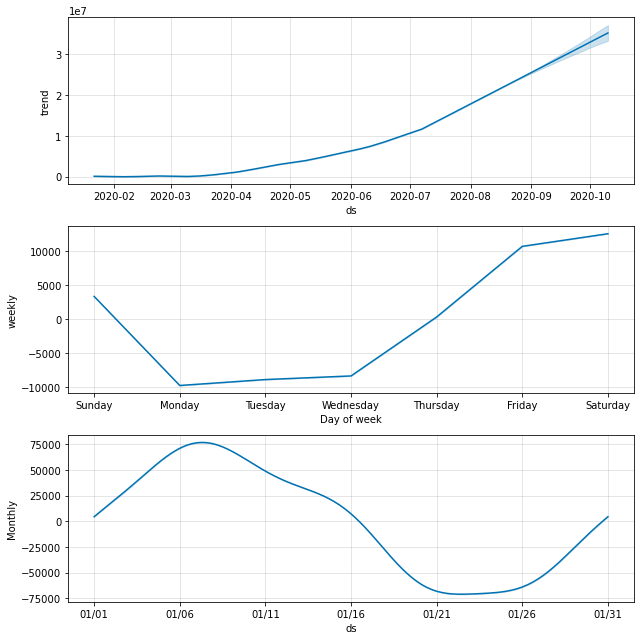

In [39]:
m.plot(predictions_world);
m.plot_components(predictions_world);
check_metrics(daily_new_test, predictions_world)

**Predicting the number of confirmed cases of novel coronavirus disease - NORTH MACEDONIA**

In [40]:
# Macedonia
data_macedonia = df[['DATE','DAILY NEW CASES']]
data_macedonia.columns = ['ds','y']
m = Prophet()
m.add_seasonality(name='Monthly', period=30.42, fourier_order=5)
daily_new_train, daily_new_test, divisor = train_test_split(data_macedonia, 90)
daily_new_train.shape , daily_new_test.shape
m.fit(daily_new_train)
future_dates_mk = m.make_future_dataframe(periods=26)
predictions_mk = m.predict(future_dates_mk)
predictions_mk.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
258,2020-10-06,118.272101,63.075292,146.128478,116.001174,120.179826,-5.725443,-5.725443,-5.725443,-13.405206,-13.405206,-13.405206,-7.679763,-7.679763,-7.679763,0.0,0.0,0.0,104.866895
259,2020-10-07,118.168418,72.718962,153.995996,115.706223,120.216690,-6.163586,-6.163586,-6.163586,-4.570085,-4.570085,-4.570085,1.593502,1.593502,1.593502,0.0,0.0,0.0,113.598334
260,2020-10-08,118.064736,83.637917,165.165650,115.484312,120.195812,-1.654861,-1.654861,-1.654861,5.064967,5.064967,5.064967,6.719828,6.719828,6.719828,0.0,0.0,0.0,123.129703
261,2020-10-09,117.961053,96.994563,175.260746,115.210725,120.246271,5.267760,5.267760,5.267760,16.705969,16.705969,16.705969,11.438208,11.438208,11.438208,0.0,0.0,0.0,134.667022
262,2020-10-10,117.857371,104.418163,184.990762,115.003220,120.346285,10.180198,10.180198,10.180198,24.595295,24.595295,24.595295,14.415096,14.415096,14.415096,0.0,0.0,0.0,142.452666


R-square Score: -0.3076128571461205


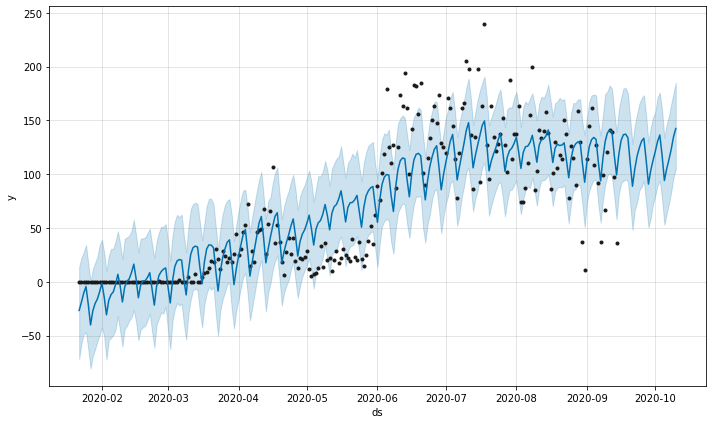

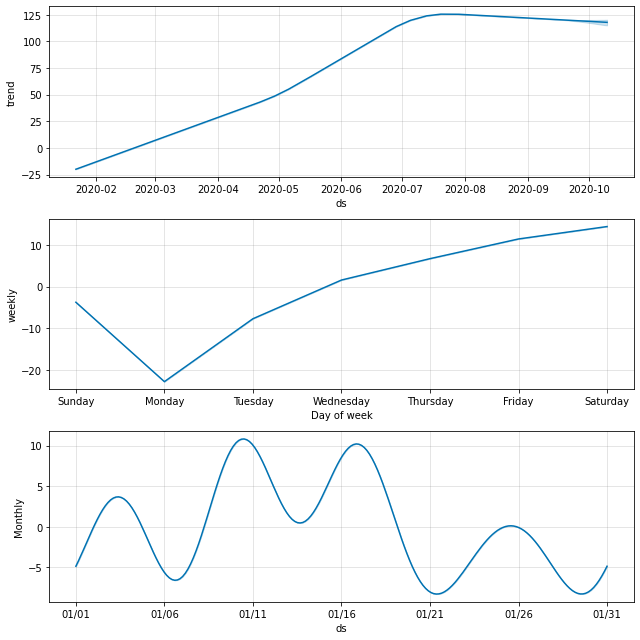

In [41]:
m.plot(predictions_mk);
m.plot_components(predictions_mk);
check_metrics(daily_new_test, predictions_mk)

**Covid-19 forecasting using ARIMA model<br>
`ARIMA: AR-Autoregression, I-Integrated, MA-Moving Average`<br>
`Autoregression (AR)` refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.<br>
`Integrated (I)` represents the differencing of raw observations to allow for the time series to become stationary, i.e., data values are replaced by the difference between the data values and the previous values.<br>
`Moving average (MA)` incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.<br>
When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.<br>
To check if the data is statinary, I used `Augmented Dickey–Fuller test (ADF) test`. <br>
`Null Hypothesis (H0)`: It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.<br>
`Alternate Hypothesis (H1)`: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.<br>
The result from the test is the p-value. <br>
If `p-value > 0.05:` Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br>
If `p-value <= 0.05:` Reject the null hypothesis (H0), the data does not have a unit root and is stationary.**


In [36]:
from statsmodels.tsa.stattools import adfuller
macedonia_dataframe = df[['DATE','DAILY NEW CASES']]
macedonia_dataframe['DATE']=pd.to_datetime(macedonia_dataframe['DATE'])
macedonia_dataframe.set_index('DATE', inplace=True)
result = adfuller(macedonia_dataframe.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.324865
p-value: 0.978457


**After running the previous cell, we can see that the p-value is `0.97` which tells us that the data is not stationary and we have to make manual implementation of the differencing operation. <br>Then, to train any machine learning model irrespective what type of dataset is being used you have to split the dataset into training data and testing(validation) data.**

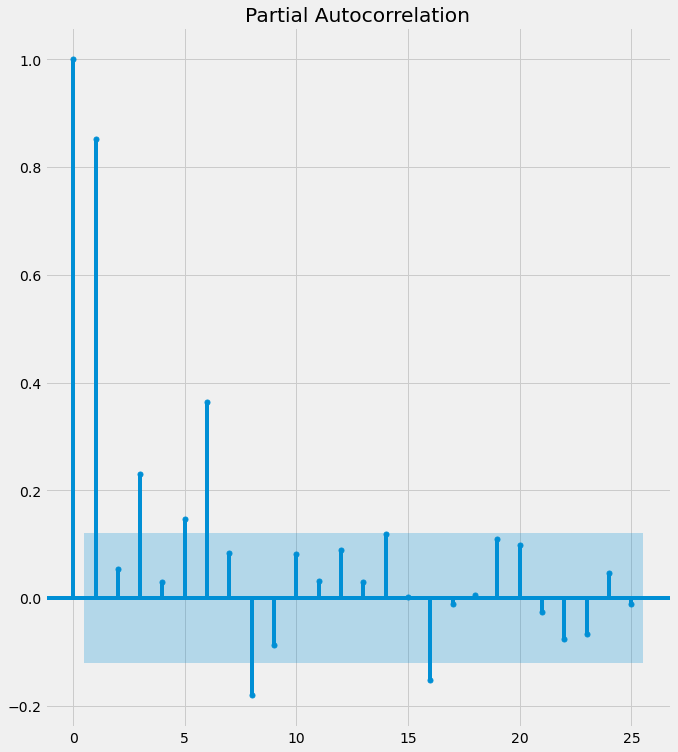

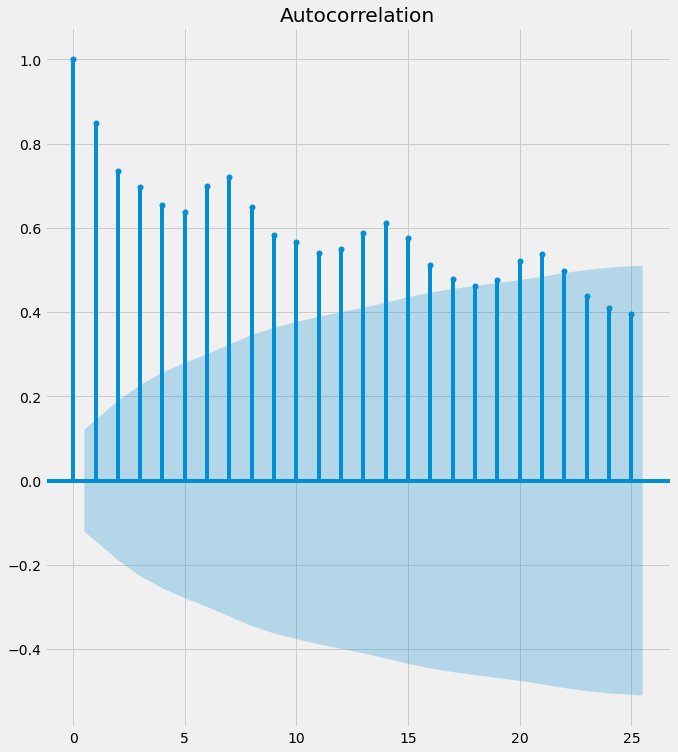

In [37]:
plot_pacf(macedonia_dataframe['DAILY NEW CASES']);
plot_acf(macedonia_dataframe['DAILY NEW CASES']);

In [38]:
#ARIMA
macedonia_dataframe['stationary']=macedonia_dataframe['DAILY NEW CASES'].diff()
split = round((80/100)*macedonia_dataframe.shape[0])
stationary_data = macedonia_dataframe[1:split]
stationary_data_test = macedonia_dataframe[split:]
del stationary_data['DAILY NEW CASES']
del stationary_data_test['DAILY NEW CASES']

In [39]:
check_stationary = adfuller(stationary_data.dropna())
print('ADF Statistic: %f' % check_stationary[0])
print('p-value: %f' % check_stationary[1])

ADF Statistic: -6.005912
p-value: 0.000000


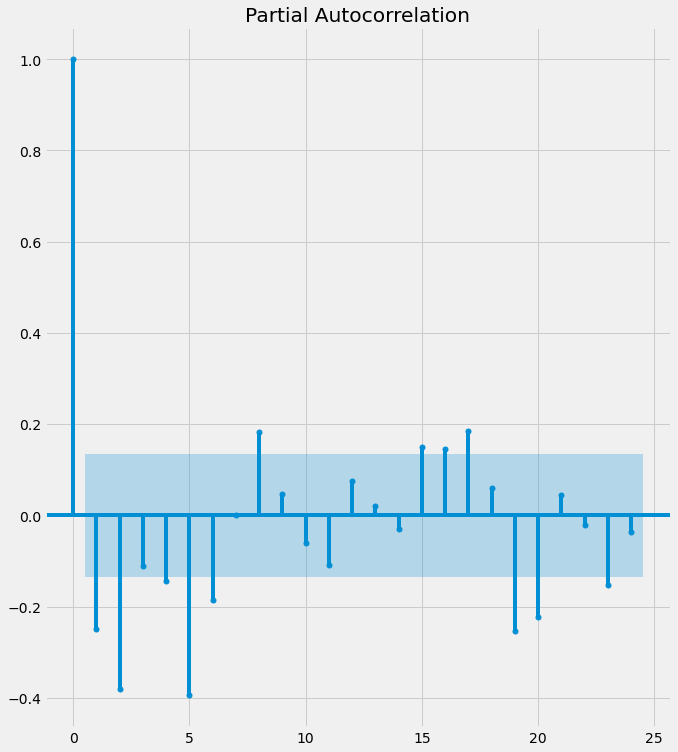

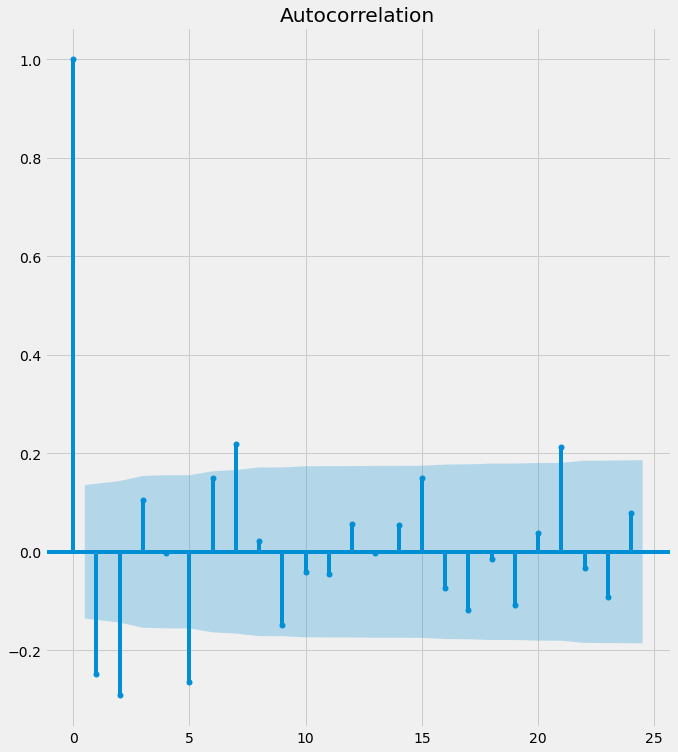

In [40]:
plot_pacf(stationary_data['stationary']);
plot_acf(stationary_data['stationary']);


In [41]:
stationary_data_test.dropna()

,stationary
DATE,
2020-08-19,-24.0
2020-08-20,12.0
2020-08-21,-4.0
2020-08-22,36.0
2020-08-23,-13.0
2020-08-24,-59.0
2020-08-25,48.0
2020-08-26,-11.0
2020-08-27,-25.0


In [42]:
indices = pd.date_range(start='19/08/2020', periods=70)
indices

DatetimeIndex(['2020-08-19', '2020-08-20', '2020-08-21', '2020-08-22',
               '2020-08-23', '2020-08-24', '2020-08-25', '2020-08-26',
               '2020-08-27', '2020-08-28', '2020-08-29', '2020-08-30',
               '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03',
               '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07',
               '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11',
               '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15',
               '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19',
               '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23',
               '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27',
               '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01',
               '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05',
               '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09',
               '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13',
      

**Check the best `p,q,d` values to train the model. The smaller the `AIC(Akaike information criterion)`, the better the fit.**

In [ ]:
p=d=q=range(0,21)
pqd = list(itertools.product(p,d,q))
for param in pqd:
    try:
        m=ARIMA(stationary_data,order = param)
        m_fit = m.fit()
        print(param,m_fit.aic)
    except:
        continue

**Train the model. From the output of the previous cell we noticed that `(17,0,12)` was the best order.
An alpha of `0.05` means that the `ARIMA model` will estimate the upper and lower values around the forecast where there is a only a `5%` chance that the real value will not be in that range.**

In [43]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(stationary_data.dropna(),order=(20,0,6))
model_arima_fit = model_arima.fit()
fitted = model_arima.fit(disp=-1)  
# Forecast
fc, se, conf = fitted.forecast(70, alpha=0.05)  # 95% conf

stationary_data_test

# Make as pandas series
fc_series = pd.Series(fc, index=indices)
lower_series = pd.Series(conf[:, 0], index=indices)
upper_series = pd.Series(conf[:, 1], index=indices)



**Visualize the result of the forecast. Data visualization gives us a clear idea of what the information means by giving it visual context through maps or graphs. This makes the data more natural for the human mind to comprehend and therefore makes it easier to identify trends, patterns, and outliers within large data sets.**

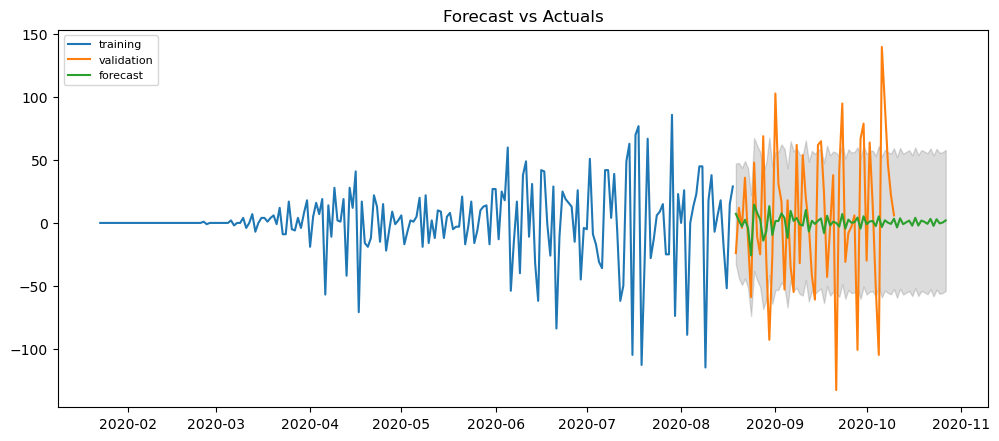

In [50]:
# Plot
plt.figure(figsize=(12,5), dpi=100)

plt.plot(stationary_data, label='training')
plt.plot(stationary_data_test, label='validation')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [132]:
r2_score(fc_series, stationary_data_test)


-8.953064357608255

## XGBoost (eXtreme Gradient Boost)

Import packages and libraries

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

**Read the data and then split into train and test set.**

In [ ]:
nmk_df = df[['DATE','DAILY NEW CASES']]
nmk_df['DATE']=pd.to_datetime(nmk_df['DATE'])
nmk_df.set_index('DATE', inplace=True)

In [43]:
nmk_train, nmk_test, divisor = train_test_split(nmk_df, 80)

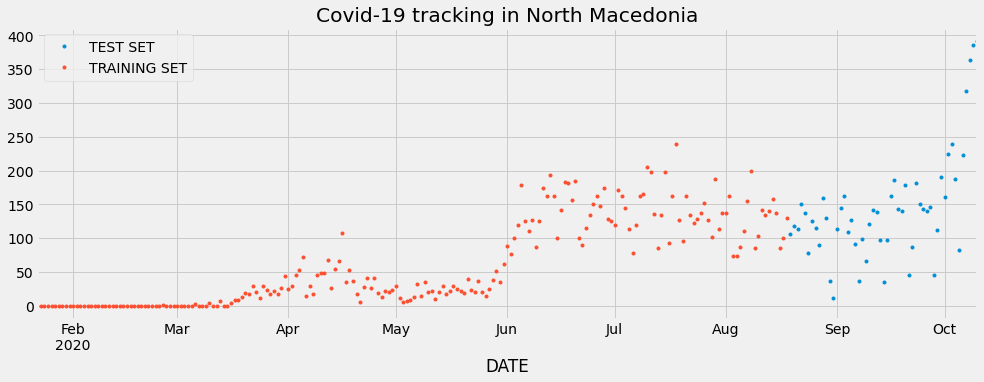

In [44]:
_ = nmk_test \
    .rename(columns={'DAILY NEW CASES': 'TEST SET'}) \
    .join(nmk_train.rename(columns={'DAILY NEW CASES': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Covid-19 tracking in North Macedonia', style='.')

**Create Time Series Features**

In [45]:
def create_new_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [46]:
X_train, y_train = create_new_features(nmk_train, label='DAILY NEW CASES')
X_test, y_test = create_new_features(nmk_test, label='DAILY NEW CASES')

In [47]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[11:56:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

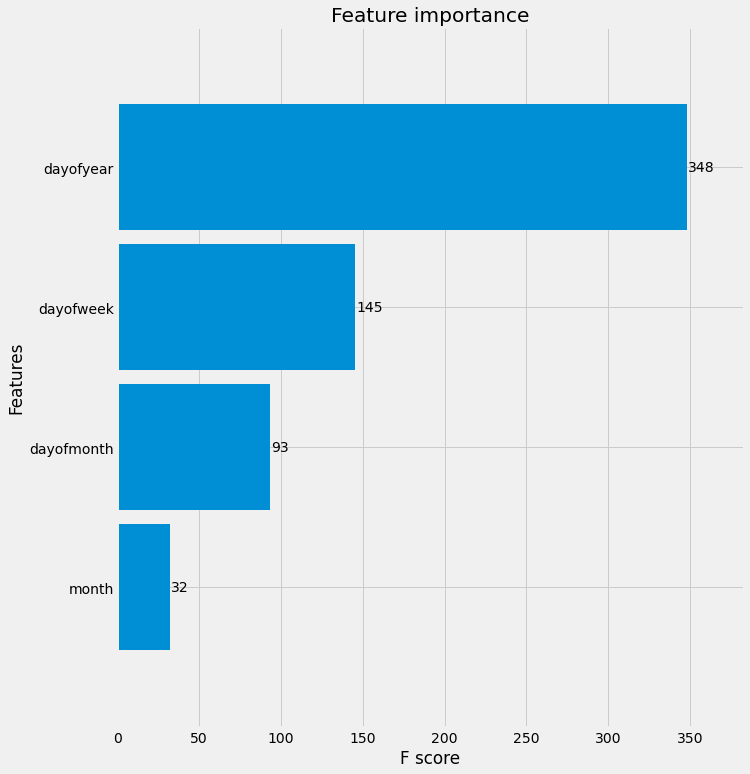

In [48]:
_ = plot_importance(reg, height=0.9)

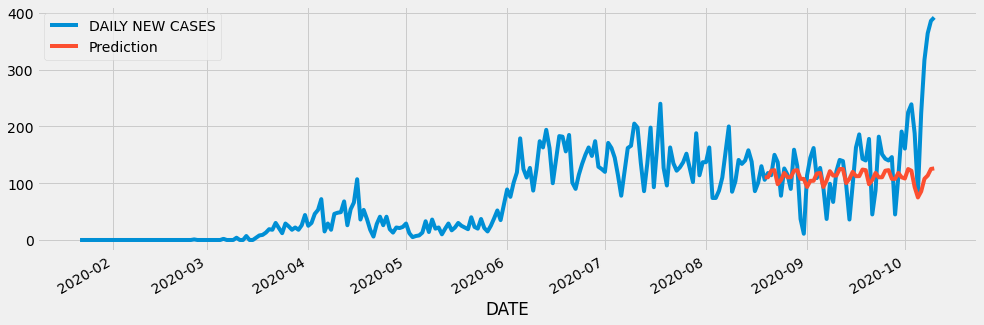

In [49]:
nmk_test['Prediction'] = reg.predict(X_test)
nmk_all = pd.concat([nmk_test, nmk_train], sort=False)
_ = nmk_all[['DAILY NEW CASES','Prediction']].plot(figsize=(15, 5))

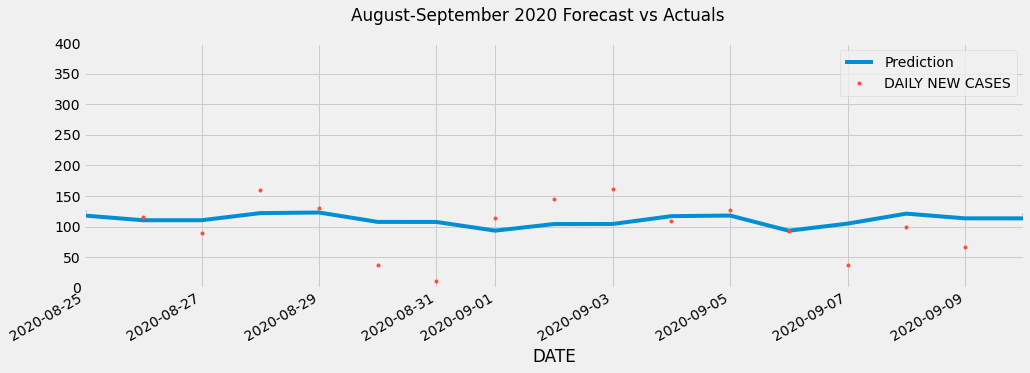

In [50]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = nmk_all[['Prediction','DAILY NEW CASES']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-25-2020', upper='09-10-2020')
ax.set_ylim(0, 400)
plot = plt.suptitle('August-September 2020 Forecast vs Actuals')

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
mean_absolute_percentage_error(y_true=nmk_test['DAILY NEW CASES'],
                   y_pred=nmk_test['Prediction'])

56.42893596870502

In [53]:
nmk_test['error'] = nmk_test['DAILY NEW CASES'] - nmk_test['Prediction']
nmk_test['abs_error'] = nmk_test['error'].apply(np.abs)
error_by_day = nmk_test.groupby(['year','month','dayofmonth']) \
    .mean()[['DAILY NEW CASES','Prediction','error','abs_error']]

In [54]:
error_by_day.sort_values('error', ascending=True).head(10)

DAILY NEW CASES  Prediction      error  abs_error
year month dayofmonth                                                   
2020 8     31                     11.0  107.584839 -96.584839  96.584839
     9     14                     36.0  107.658577 -71.658577  71.658577
     8     30                     37.0  107.662125 -70.662125  70.662125
     9     7                      37.0  104.879425 -67.879425  67.879425
           28                     45.0  107.584839 -62.584839  62.584839
           21                     45.0  105.645432 -60.645432  60.645432
           9                      67.0  113.484329 -46.484329  46.484329
           22                     87.0  118.101631 -31.101631  31.101631
     8     24                     78.0  105.645432 -27.645432  27.645432
     9     8                      99.0  121.164772 -22.164772  22.164772

In [55]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

DAILY NEW CASES  Prediction       error   abs_error
year month dayofmonth                                                     
2020 10    10                    392.0  126.091484  265.908516  265.908516
           9                     386.0  125.113724  260.886276  260.886276
           8                     364.0  113.484329  250.515671  250.515671
           7                     317.0  107.763680  209.236320  209.236320
           6                     223.0   85.494637  137.505363  137.505363
           3                     239.0  121.964317  117.035683  117.035683
           2                     225.0  124.984764  100.015236  100.015236
     8     31                     11.0  107.584839  -96.584839   96.584839
     10    4                     188.0   93.271156   94.728844   94.728844
     9     30                    191.0  110.421188   80.578812   80.578812

In [56]:
# Best absolute predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

DAILY NEW CASES  Prediction     error  abs_error
year month dayofmonth                                                  
2020 9     6                      92.0   93.271156 -1.271156   1.271156
           13                     97.0  100.259460 -3.259460   3.259460
     8     19                    106.0  110.421188 -4.421188   4.421188
           26                    115.0  110.421188  4.578812   4.578812
     9     29                    112.0  118.101631 -6.101631   6.101631
     8     29                    130.0  123.028343  6.971657   6.971657
     9     10                    121.0  113.484329  7.515671   7.515671
     8     20                    118.0  110.421188  7.578812   7.578812
           25                    126.0  118.101631  7.898369   7.898369
           21                    114.0  122.050583 -8.050583   8.050583

## Linear Regression

In [198]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [199]:
nmk_df = df[['DATE','DAILY NEW CASES']]
nmk_df['DATE']=pd.to_datetime(nmk_df['DATE'])

In [200]:
nmk_df['DATE'] = nmk_df['DATE'].apply(lambda x: x.toordinal())

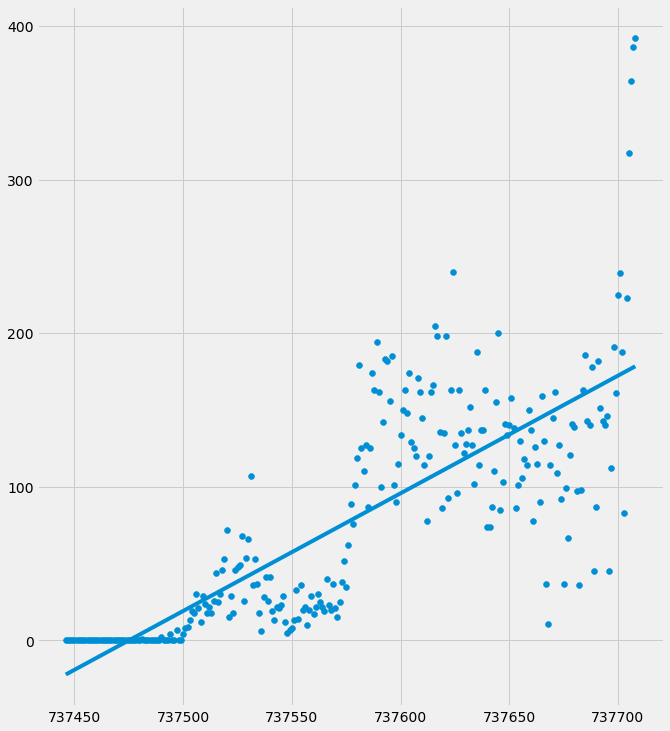

In [202]:
features_to_use = ['DATE']
x = np.array(nmk_df[features_to_use])
y = np.array(nmk_df['DAILY NEW CASES'])
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size =0.8)

In [203]:
r

0.7778737020271301

In [204]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [205]:
y_pred = model.predict(X_test)

In [206]:
nmk_all = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

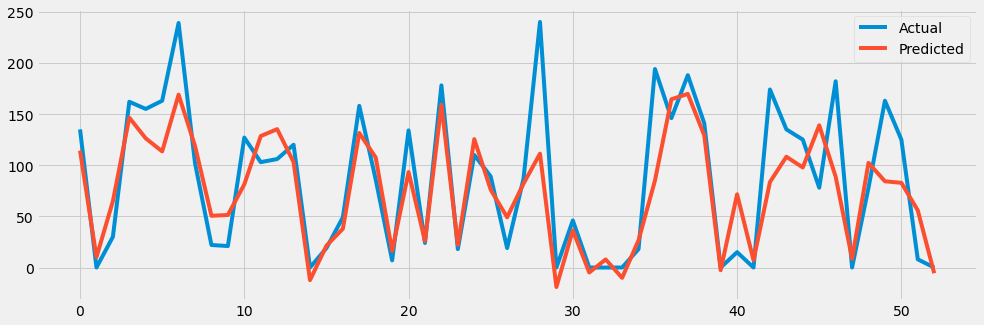

In [207]:

_ = nmk_all[['Actual','Predicted']].plot(figsize=(15, 5))

In [208]:
comp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comp_df.head(10))

   Actual   Predicted
0   135.0  114.257640
1     0.0   10.137111
2    30.0   64.819115
3   162.0  146.467587
4   155.0  126.242736
5   163.0  113.508571
6   239.0  168.939644
7   102.0  118.752051
8    22.0   50.586813
9    21.0   51.335881


In [209]:
r2_value = r2_score(y_test, y_pred) 
print("R^2 Value: \n", r2_value)

R^2 Value: 
 0.6785051539085056


In [210]:
future_dates_indices = pd.date_range(start='10/11/2020', periods=20)

In [211]:
future_dates_indices = future_dates_indices.strftime('%Y-%m-%d')

In [212]:
tmp=[]
for date in future_dates_indices:
    entry = [pd.Timestamp(date).toordinal()]
    tmp.append(entry)
future_dates = np.array(tmp)

In [213]:
future_cases = model.predict(future_dates)

In [214]:
future_cases

array([174.93219228, 175.68126083, 176.43032939, 177.17939794,
       177.92846649, 178.67753504, 179.4266036 , 180.17567215,
       180.9247407 , 181.67380925, 182.42287781, 183.17194636,
       183.92101491, 184.67008346, 185.41915202, 186.16822057,
       186.91728912, 187.66635767, 188.41542623, 189.16449478])

In [215]:
data=[]
for i in range(0, future_dates_indices.size):
    data.append([future_dates_indices[i], future_cases[i]])

In [216]:
future_df = pd.DataFrame(data, columns = ['Date', 'Number of cases']) 

In [217]:
future_df

,Date,Number of cases
0,2020-10-11,174.932192
1,2020-10-12,175.681261
2,2020-10-13,176.430329
3,2020-10-14,177.179398
4,2020-10-15,177.928466
5,2020-10-16,178.677535
6,2020-10-17,179.426604
7,2020-10-18,180.175672
8,2020-10-19,180.924741
9,2020-10-20,181.673809
